In [1]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [41]:
#|export
# Python native modules
import os
from torch.multiprocessing import Queue
from typing import Tuple,NamedTuple
# Third party libs
from fastcore.all import add_docs
import matplotlib.pyplot as plt
import torchdata.datapipes as dp
from IPython.core.display import clear_output
import torch
import numpy as np
# Local modules
from fastrl.core import Record
from fastrl.loggers.core import LoggerBase,LogCollector,is_record
# from fastrl.torch_core import *

/tmp/ipykernel_1402/1768756871.py:10: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [4]:
#|default_exp loggers.jupyter_visualizers

# Visualizers 
> Iterable pipes for displaying environments as they run using `typing.NamedTuples` with `image` fields

In [62]:
#|export
class SimpleJupyterVideoPlayer(dp.iter.IterDataPipe):
    def __init__(self, 
                 source_datapipe=None, 
                 between_frame_wait_seconds:float=0.1
        ):
        self.source_datapipe = source_datapipe
        self.between_frame_wait_seconds = 0.1

    def dequeue(self): 
        while self.buffer: yield self.buffer.pop(0)

        
    def __iter__(self) -> Tuple[NamedTuple]:
        img = None
        for record in self.source_datapipe:
            # for o in self.dequeue():
            if is_record(record):
                if record.value is None: continue
                if img is None: img = plt.imshow(record.value)
                img.set_data(record.value) 
                plt.axis('off')
                display(plt.gcf())
                clear_output(wait=True)
            yield record
add_docs(
    SimpleJupyterVideoPlayer,
    """Displays video from a `source_datapipe` that produces `typing.NamedTuples` that contain an `image` field.
       This only can handle 1 env input.""",
    dequeue="Grabs records from the `main_queue` and attempts to display them"
)

In [63]:
#|export
class ImageCollector(dp.iter.IterDataPipe):
    title:str='image'

    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe

    def convert_np(self,o):
        if isinstance(o,torch.Tensor): return o.detach().numpy()
        elif isinstance(o,np.ndarray): return o
        else:                          raise ValueError(f'Expects Tensor or np.ndarray not {type(o)}')
    
    def __iter__(self):
        # for q in self.main_buffers: q.append(Record('image',None))
        yield Record(self.title,None)
        for steps in self.source_datapipe:
            if isinstance(steps,dp.DataChunk):
                for step in steps:
                    yield Record(self.title,self.convert_np(step.image))
            else:
                yield Record(self.title,self.convert_np(steps.image))
            yield steps

In [64]:
from fastrl.envs.gym import GymDataPipe

In [65]:
#|eval:false
%matplotlib inline

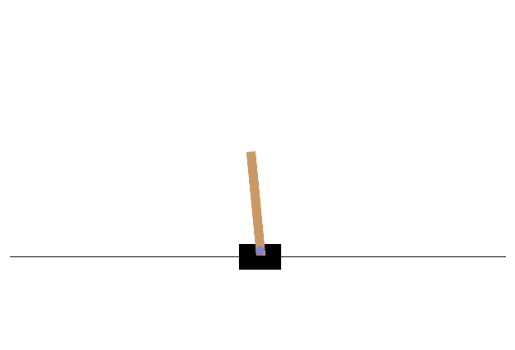

In [69]:

pipe = GymDataPipe(['CartPole-v1'],None,n=100,seed=0,include_images=True)
pipe = ImageCollector(pipe)
pipe = SimpleJupyterVideoPlayer(pipe)

for o in pipe: pass

In [68]:
#|hide
#|eval: false
!nbdev_export

477.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/usr/local/lib/python3.8/dist-packages/nbdev/export.py:54: UserWarning: Notebook '/home/fastrl_user/fastrl/nbs/07_Agents/02_Continuous/12u_agents.ppo.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
